Reference:
# Phenomenological Model of Neocortical Synapses,
Neural Networks with Dynamic Synapses,
Misha Tsodyks, Klaus Pawelzik, Henry Markram.
Neural Computation 10, 821-835 (1998).



The model assumes that a synapse is characterized by a finite amount of resources. Each presynaptic spike (arriving at time t_sp) activates a fraction (U_se, utilization of synaptic efficacy) of resources, which then quickly inactivate with a time constant of few milliseconds (tau_in) and recover with a time constant of about 1 second (tau_rec). The corresponding kinetic equations read:

    dx/dt = (z/tau_rec) - U_se * x(t_sp - 0) * delta(t - t_sp) // recovered pool

    dy/dt = -(y/tau_in) + U_se * x(t_sp - 0) * delta(t - t_sp) // active pool

    dz/dt = (y/tau_in) - (z/tau_rec) // inactive pool

The postsynaptic current is taken to be proportional to the active pool.

    I_syn (t) = A_se * y(t)

where, A_se is absolute synaptic strength which can be exhibited only by activating all the resources.

A_se and U_se are two major parameters of the model. U_se determines the dynamics of synaptic response.


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal as sig

In [14]:
# Creating a stim signal with 8 pulses at 50Hz
stimSignal50Hz = sig.unit_impulse(20000,range(4462,4462+8*400,400))
# Creating a stim signal with 8 pulses at 20Hz
stimSignal20Hz = sig.unit_impulse(20000,range(4462,4462+8*1000,1000))

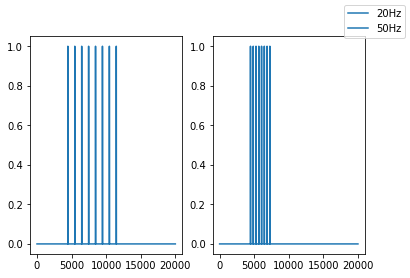

In [15]:
fig,axs = plt.subplots(1,2)
axs[0].plot(stimSignal20Hz,label='20Hz')
axs[1].plot(stimSignal50Hz,label='50Hz')
fig.legend()
plt.show()

In [16]:
def basic_synapse(stim):
    x0=np.array([100])
    U_se = 0.5
    t_rec= 1600
    t_in = 60

    x = np.append(x0,np.zeros([len(stim)-1,1]))
    y = np.zeros([len(stim),1])
    z = np.zeros([len(stim),1])

    for i in range(len(stim)-1):
        dx = (z[i]/t_rec)-U_se*x[i]*stim[i]
        dy = -(y[i]/t_in)+U_se*x[i]*stim[i]
        dz = (y[i]/t_in) - (z[i]/t_rec)

        x[i+1] = x[i]+dx
        y[i+1] = y[i]+dy
        z[i+1] = z[i]+dz
    
    plt.plot(np.linspace(0,1000,20000),x,label='Recovered')
    plt.plot(np.linspace(0,1000,20000),y,label='Active')
    plt.plot(np.linspace(0,1000,20000),z,label='Inactive')
    plt.suptitle('Basic synaptic pools without facilitation')
    plt.legend()

    return [x,y,z]

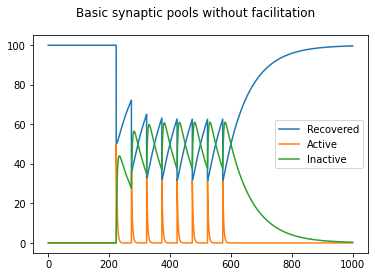

In [17]:
_ = basic_synapse(stimSignal20Hz)

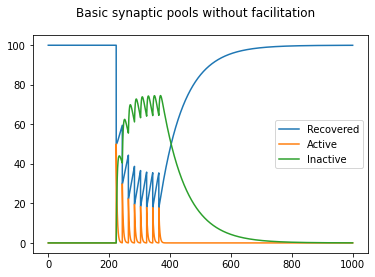

In [18]:
_ = basic_synapse(stimSignal50Hz)

# Implementing faciliating and depressing synapses

Synapses between pyramidal and inhibitory interneurons are often facilitating. A standard way of modelling facilitating synapses is by introducing a facilitation factor, which is elecated by each spike by a certain amount and decays between spikes.

To add facilitation into the synaptic model, is value of U_se is increased by a certain amount due to each presynaptic spike. The instantaneous U_se is referred to as U1_se. The resulting model includes both facilitating and depressing mechanisms.

For a simple kinetic mechanism, assume that an AP causes a fraction of U_se calcium channels to open, which subsequently close with a time constant of tau_facil. The fraction of opened calcium channels determines the current value of U1_se.

The kinetic equation this reads:

    dU1_se/dt = -(U1_se/tau_facil) + U_Se * (1-U1_se) * delta(t - t_sp)

The newer synapses would look like following:

In [33]:
def e2eSynapse(stim):
    GOhm = 1e9
    pA = 1e-12
    x0=np.array([100])
    U_se = np.array([0.5])

    tau_mem = 1200
    tau_rec= 2600
    tau_in = 30
    tau_facil = 10600

    A_se = 1540*pA
    R_in = 0.1*GOhm

    x = np.append(x0,np.zeros([len(stim)-1,1]))
    y = np.zeros([len(stim),1])
    z = np.zeros([len(stim),1])
    u = np.append(U_se,np.zeros([len(stim)-1,1]))
    I_syn = np.zeros([len(stim),1])
    V_syn = np.zeros([len(stim),1])

    for i in range(len(stim)-1):
        dx =  (z[i]/tau_rec)    - u[i] * x[i] * stim[i]
        dy = -(y[i]/tau_in)     + u[i] * x[i] * stim[i]
        dz =  (y[i]/tau_in)     - (z[i]/tau_rec)
        du = -(u[i]/tau_facil)  + U_se * (1 - u[i]) * stim[i]

        x[i+1] = x[i]+dx
        y[i+1] = y[i]+dy
        z[i+1] = z[i]+dz
        u[i+1] = u[i]+du

        I_syn[i] = A_se * y[i]
        V_syn[i+1] = (-V_syn[i] + (R_in * I_syn[i])) / tau_mem

    fig,axs = plt.subplots(2,2)
    axs[0,0].plot(np.linspace(0,1000,num=20000),stim,'b',label='pre-synaptic firing')
    axs[1,0].plot(np.linspace(0,1000,num=20000),V_syn,'r',label='EPSPs in post-syn PyC')
    axs[0,1].plot(np.linspace(0,1000,num=20000),x,label='Recovered pool')
    axs[0,1].plot(np.linspace(0,1000,num=20000),y,label='Active pool')
    axs[0,1].plot(np.linspace(0,1000,num=20000),z,label='Inactive pool')
    axs[1,1].plot(np.linspace(0,1000,num=20000),u,label='Facilitation')
    fig.legend(bbox_to_anchor=(1.3,0.9))
    fig.suptitle('E2E synapse with facilitation')
    fig.show()

    return [V_syn,x,y,z,u]
    

In [28]:
def e2iSynapse(stim):
    GOhm = 1e9
    pA = 1e-12
    x0=np.array([100])
    U_se = np.array([0.5])

    tau_mem = 1200
    tau_rec= 2600
    tau_in = 30
    tau_facil = 10600

    A_se = 1540*pA
    R_in = 1*GOhm

    x = np.append(x0,np.zeros([len(stim)-1,1]))
    y = np.zeros([len(stim),1])
    z = np.zeros([len(stim),1])
    u = np.append(U_se,np.zeros([len(stim)-1,1]))
    I_syn = np.zeros([len(stim),1])
    V_syn = np.zeros([len(stim),1])

    for i in range(len(stim)-1):
        dx =  (z[i]/tau_rec)    - u[i] * x[i] * stim[i]
        dy = -(y[i]/tau_in)     + u[i] * x[i] * stim[i]
        dz =  (y[i]/tau_in)     - (z[i]/tau_rec)
        du = -(u[i]/tau_facil)  + U_se * (1 - u[i]) * stim[i]

        x[i+1] = x[i]+dx
        y[i+1] = y[i]+dy
        z[i+1] = z[i]+dz
        u[i+1] = u[i]+du

        I_syn[i] = A_se * y[i]
        V_syn[i+1] = (-V_syn[i] + (R_in * I_syn[i])) / tau_mem

    fig,axs = plt.subplots(2,2)
    axs[0,0].plot(np.linspace(0,1000,num=20000),stim,'b',label='pre-synaptic firing')
    axs[1,0].plot(np.linspace(0,1000,num=20000),V_syn,'r',label='EPSPs in post-syn IN')
    axs[0,1].plot(np.linspace(0,1000,num=20000),x,label='Recovered pool')
    axs[0,1].plot(np.linspace(0,1000,num=20000),y,label='Active pool')
    axs[0,1].plot(np.linspace(0,1000,num=20000),z,label='Inactive pool')
    axs[1,1].plot(np.linspace(0,1000,num=20000),u,label='Facilitation')
    fig.legend(bbox_to_anchor=(1.3,0.9))
    fig.suptitle('E2I synapse with facilitation')
    fig.show()

    return [V_syn,x,y,z,u]
    

c:\venvs\venv-lab\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


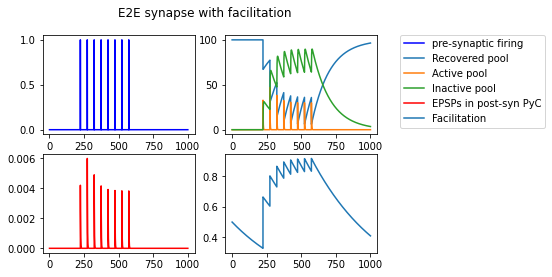

In [34]:
_ = e2eSynapse(stimSignal20Hz)

c:\venvs\venv-lab\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


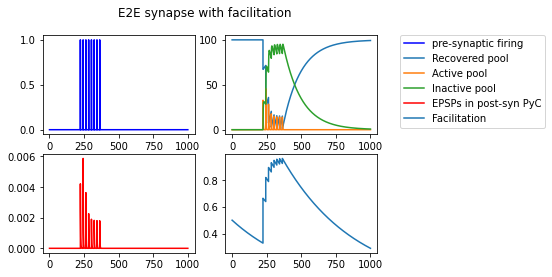

In [35]:
_ = e2eSynapse(stimSignal50Hz)

c:\venvs\venv-lab\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


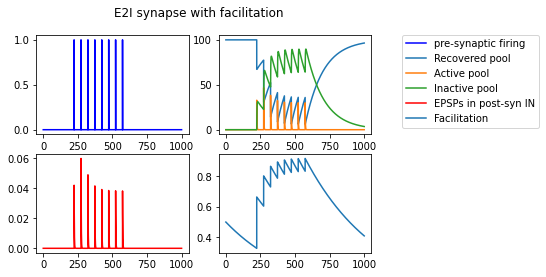

In [31]:
_ = e2iSynapse(stimSignal20Hz)

c:\venvs\venv-lab\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


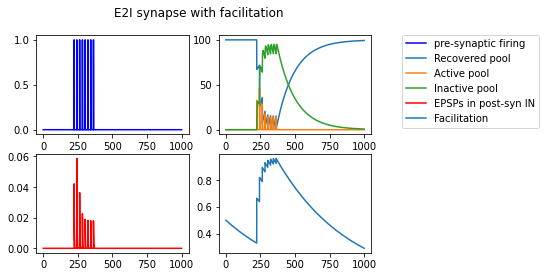

In [32]:
_ = e2iSynapse(stimSignal50Hz)

# Implementing RK(4) method

In [1]:
from scipy.integrate import odeint, solve_ivp